# MIBCI-QCNNs: Training

This notebook contains all the steps taken to develop an [EEGNet](https://arxiv.org/abs/1611.08024)-based Brain Computer Interface using the [Physionet Motor Movement/Imagery dataset](https://physionet.org/content/eegmmidb/1.0.0/). Firstly, the data is loaded (or downloaded if is not available) and preprocessed according the selected data-reduction settings. Then a 5-fold global model is trained over the preprocessed data.

## Preprocess the data
 
The data we are using here is the [Physionet Motor Movement/Imagery dataset](https://physionet.org/content/eegmmidb/1.0.0/). It is composed of a 64 Electroencephalograph recordings of 109 subjects that perform up to 4 motor imagery tasks. There are also recording of motor movement that are not interesting under the motor imagery paradigm. To get the data of the dataset we have included the `get_data` function, which is adapted from [this version](https://github.com/MHersche/eegnet-based-embedded-bci/blob/master/get_data.py). If the files haven't been downloaded yet it will download them in the `Dataset`folder. The downsampling factor is set here to be `ds=2` and the other parameters are the default (`T=3`, `Nchans=64` and `Nclasses=4`).

 > Be aware that the download can take a while

In [1]:
import numpy as np
from utils.get_data import get_data

In [2]:
X, y, subs = get_data('./Dataset/', ds=2)
print(X.shape, y.shape, subs.shape)

Data from runs: [1, 4, 6, 8, 10, 12, 14]
Processing subject 001 1/105...Ok
Processing subject 002 2/105...Ok
Processing subject 003 3/105...Ok
Processing subject 004 4/105...Ok
Processing subject 005 5/105...Ok
Processing subject 006 6/105...Ok
Processing subject 007 7/105...Ok
Processing subject 008 8/105...Ok
Processing subject 009 9/105...Ok
Processing subject 010 10/105...Ok
Processing subject 011 11/105...Ok
Processing subject 012 12/105...Ok
Processing subject 013 13/105...Ok
Processing subject 014 14/105...Ok
Processing subject 015 15/105...Ok
Processing subject 016 16/105...Ok
Processing subject 017 17/105...Ok
Processing subject 018 18/105...Ok
Processing subject 019 19/105...Ok
Processing subject 020 20/105...Ok
Processing subject 021 21/105...Ok
Processing subject 022 22/105...Ok
Processing subject 023 23/105...Ok
Processing subject 024 24/105...Ok
Processing subject 025 25/105...Ok
Processing subject 026 26/105...Ok
Processing subject 027 27/105...Ok
Processing subject 028 

Once the data is loaded and preprocessed, it must be saved in a folder using the names `samples.npy`, `labels.npy` and `subs.npy`.


In [3]:
processedPath = 'ds2/'

try:
    os.mkdir(processedPath)
except FileExistsError:
    pass

np.save(processedPath+'samples.npy', X)
np.save(processedPath+'labels.npy', y)
np.save(processedPath+'subs.npy', subs)

## Global model training

The validation method used here is 5-fold cross-validation across subjects. This means that for each global 'model' 5 different models will be trained, using an iterating fifth of the subjects as the validation set.

The model architecture is the displayed in the following picture, which is further detailed in the table bellow. In short it is based on the [EEGNet](https://arxiv.org/abs/1611.08024), a Convolutional Neural Network that showed its versatility when EEG recordings must be processed. The only changes are:

- The substitution of the ELU activation function for the LeakyReLU which is cheaper to implement in hardware.

- The remove of the Dropout and BatchNorm layers.

![EEGNet-based model architecture (If you are seeing this in GitHub there is a bug that doesn't display the pictures)](img/EEGNet.svg)


|     Layer          |     #   filters    |     Padding    |     Kernel           |     #   parms          |     Activation       |     Output   shape           |
|--------------------|--------------------|----------------|----------------------|------------------------|----------------------|------------------------------|
|     Input          |     -              |     -          |     -                |     -                  |     -                |     (Nchan,   fs·T/ds, 1)    |
|     Conv2D         |     4              |     same       |     (1,   fs/2ds)    |     2fs/ds             |     LReLU   (0.6)    |     (Nchan,   fs·T/ds, 4)    |
|     DepthConv2D    |     2·4            |     valid      |     (Nchan,   1)     |     8Nchan             |     LReLU   (0.5)    |     (1, fs·T/ds,   8)        |
|     AvgPool2D      |     -              |     valid      |     (1,   6/ds)      |     -                  |     -                |     (1, fs·T/6,   8)         |
|     SepConv2D      |     8              |     same       |     (1,   16)        |     192                |     LReLU   (0.4)    |     (1, fs·T/6,   8)         |
|     AvgPool2D      |     -              |     valid      |     (1,   8)         |     -                  |     -                |     (1, fs·T/48,   8)        |
|     Flatten        |     -              |     -          |     -                |     -                  |     -                |     fs·T/6                   |
|     Dense          |     Nclasses       |     -          |     -                |     Nclasses fs·T/6    |     Softmax          |     Nclasses                 |

We have embebed the necesary code to normalized the data, load the correct validation subjects, create the architecture and train the five models with the fine-tunned hyperparemeters in the [utils/train_tools.py](utils/train_tools.py) file.

> The training process is relatively long, but it depends on your hardware. If you are using a GPU it can be shortened. In our case with a Quadro P2000 it takes around 45 minutes.

In [4]:
from utils.train_tools import train_global

- loss: 0.6664 - accuracy: 0.7457 - val_loss: 1.2941 - val_accuracy: 0.6224
Epoch 71/100
882/882 [==============================] - 5s 6ms/step - loss: 0.6589 - accuracy: 0.7486 - val_loss: 1.2923 - val_accuracy: 0.6233
Epoch 72/100
882/882 [==============================] - 5s 6ms/step - loss: 0.6700 - accuracy: 0.7499 - val_loss: 1.2956 - val_accuracy: 0.6233
Epoch 73/100
882/882 [==============================] - 5s 6ms/step - loss: 0.6627 - accuracy: 0.7497 - val_loss: 1.3044 - val_accuracy: 0.6224
Epoch 74/100
882/882 [==============================] - 5s 6ms/step - loss: 0.6542 - accuracy: 0.7564 - val_loss: 1.2997 - val_accuracy: 0.6202
Epoch 75/100
882/882 [==============================] - 5s 6ms/step - loss: 0.6695 - accuracy: 0.7499 - val_loss: 1.3065 - val_accuracy: 0.6219
Epoch 76/100
882/882 [==============================] - 5s 6ms/step - loss: 0.6638 - accuracy: 0.7503 - val_loss: 1.2999 - val_accuracy: 0.6222
Epoch 77/100
882/882 [==============================] - 5s 6

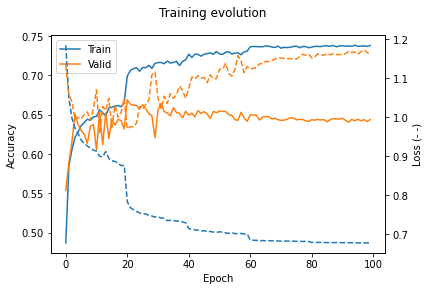

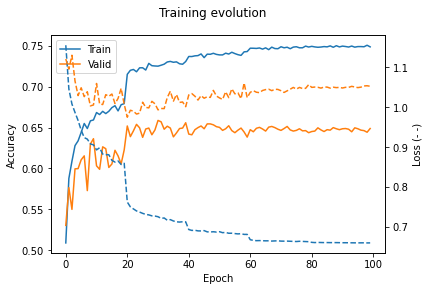

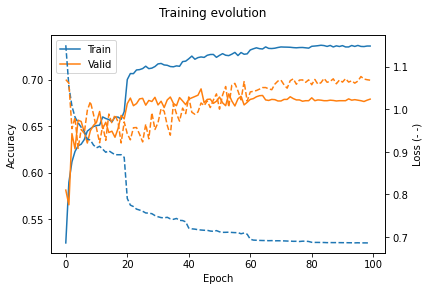

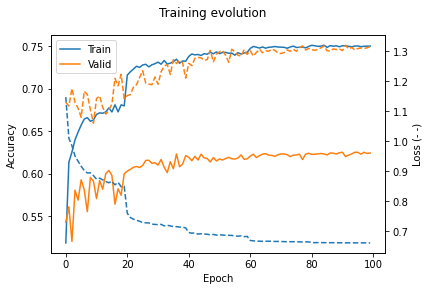

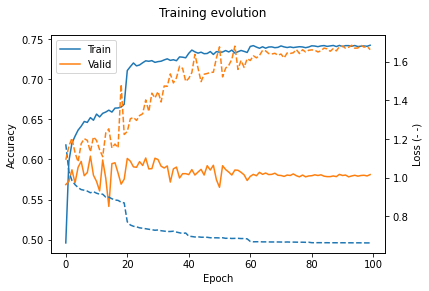

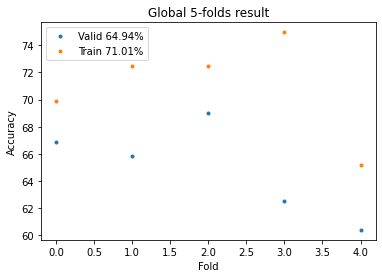

In [5]:
train_global('ds2/', ds=2)

A folder containing the models and training plots will be named at first with the format `Global_TXs_dsX_Xchans_Xclasses-datetime` and then renamed to `XX.XX-Global_TXs_dsX_Xchans_Xclasses-datetime` once the training is completed, being the header the global validation accuracy. Let's rename it to a more human-readable name, as `global_model`, that will be used in the following of this notebook.

> If there is more than one `XX.XX-Global_TXs_dsX_Xchans_Xclasses-datetime` folder, the following cell will rename the first one.

In [10]:
import os

awkward_name = [dir for dir in os.listdir() if dir[6:12] == 'Global'][0]

os.system('mv {} global_model'.format(awkward_name));

0

Both the training evolution curves and the training and validation accuracies for each fold figures should be shown when the training fold was compelted. Let's display the accuracies figure if it doesn't, since in its legend  the mean of both metrics is present . The valdiaiton accuracy is expected to be arround the 65 %.

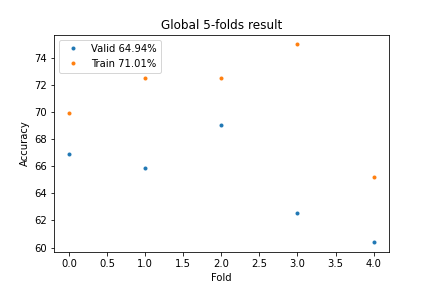

In [11]:
from IPython.display import Image
Image(filename='global_model/Global-acc.png') 